# Finding angles with gradient descent (projections & quaternions)

[Michaël Defferrard](https://deff.ch), EPFL LTS2  
[Laurène Donati](https://people.epfl.ch/laurene.donati), EPFL BIG  
[Jelena Banjac](https://people.epfl.ch/jelena.banjac), EPFL MSc in Data Science

In [1]:
from time import time
import h5py
import os
from sklearn.neighbors import NearestNeighbors

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_graphics.geometry.transformation import quaternion

---

## Data

In [2]:
n_samples = 5000

In [3]:
# location of *.h5 files
data_dir = "../data"

# half coverage (AngCoverage=0.5)
projections_filename = "ProjectionsAngles_ProjNber5000_AngCoverage0.5_AngShift1.57"

# load structures
data = h5py.File(os.path.join(data_dir, f"{projections_filename}.h5"), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (136, 136) pixels
5000 sets of 3 ground truth angles of corresponding projection images


##### Angles / Quaternions

In [4]:
low_ang = np.pi/2
high_ang = 2*np.pi-np.pi/2

euler = np.random.uniform(low=[low_ang, low_ang, low_ang], 
                          high=[high_ang, high_ang, high_ang],
                          size=(n_samples,3))
angles_predicted = [tf.Variable(quaternion.from_euler(e)) for e in euler]

print(f'{len(angles_predicted)} tensors of shape {angles_predicted[0].shape}')

# Sanity check: the quaternions represent rotations, i.e., are normalized.
assert abs(tf.reduce_mean(tf.norm(angles_predicted, axis=1) - tf.ones(n_samples, dtype=np.float64))) < 1e-5
angles_predicted = np.array(angles_predicted)
angles_predicted.shape
# angles = np.reshape(angles_predicted, (angles_predicted.shape[0], -1))
# angles.shape

5000 tensors of shape (4,)


(5000,)

In [5]:
angles_true_euler = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
angles_true = [quaternion.from_euler(e) for e in angles_true_euler]
angles_true = np.array(angles_true)
angles_true.shape

(5000, 4)

##### Projections

In [6]:
projections = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
projections.shape

(5000, 18496)

In [7]:
n_pixels = projections.shape[1]

---

## Distances

##### Angle Distances

In [8]:
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops
from tensorflow_graphics.util import shape

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",
                                 [q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product))
    
assert tf.reduce_mean(d_q(angles_true[0:3], angles_true[0:3])) < 1e-7

In [9]:
print(tf.reduce_mean(d_q(angles_true[0:3], angles_true[0:3])))
print(tf.reduce_mean(quaternion.relative_angle(angles_true[0:3], angles_true[0:3])))

tf.Tensor(7.477969526875984e-08, shape=(), dtype=float64)
tf.Tensor(1.1905330492946732e-07, shape=(), dtype=float64)


##### Projection Distance

In [10]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7

In [11]:
print(d_p(projections[0:3], projections[0:3]))

tf.Tensor(
[[0.]
 [0.]
 [0.]], shape=(3, 1), dtype=float64)


---

## Adjacency matrices

##### Projections

In [31]:
start_time = time()
projections_filename = "projections1"

if not os.path.exists(f'data/{projections_filename}_distances.npy'):
    nbrs = NearestNeighbors(n_neighbors=5, metric=d_p, algorithm='ball_tree').fit(projections)
    distances_p, indices_p = nbrs.kneighbors(projections)
    A_p = nbrs.kneighbors_graph(projections).toarray()
    
    np.save(f'data/{projections_filename}_indices', indices_p)         # Indices of the nearest points in the population matrix
    np.save(f'data/{projections_filename}_distances', distances_p)     # Array representing the lengths to points
    np.save(f'data/{projections_filename}_A', A_p) # Sparse graph showing the connections between neighboring points
    
else:
    indices_p     = np.load(f'data/{projections_filename}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
    distances_p   = np.load(f'data/{projections_filename}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
    A_p           = np.load(f'data/{projections_filename}_A.npy') # shape: NUM_IMGS, NUM_IMGS
    
print(f"--- {time() - start_time} seconds ---")

--- 10542.376056194305 seconds ---


In [34]:
A_p.shape

(5000, 5000)

##### Angles

In [35]:
start_time = time()
angles_filename = "angles1"

if not os.path.exists(f'data/{angles_filename}_distances.npy'):
    nbrs = NearestNeighbors(n_neighbors=5, metric=d_q, algorithm='ball_tree').fit(angles)
    distances_a, indices_a = nbrs.kneighbors(angles)
    A_a = nbrs.kneighbors_graph(angles).toarray()
    
    np.save(f'data/{angles_filename}_indices', indices_a)         # Indices of the nearest points in the population matrix
    np.save(f'data/{angles_filename}_distances', distances_a)     # Array representing the lengths to points
    np.save(f'data/{angles_filename}_A', A_a) # Sparse graph showing the connections between neighboring points
    
else:
    indices_a     = np.load(f'data/{angles_filename}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
    distances_a   = np.load(f'data/{angles_filename}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
    A_a           = np.load(f'data/{angles_filename}_A.npy') # shape: NUM_IMGS, NUM_IMGS
    
print(f"--- {time() - start_time} seconds ---")

--- 4102.318271160126 seconds ---


In [40]:
A_a.shape

(5000, 5000)

---

## Normalization

To normalize our distances, we simply calculate the following:

$$ z_{i} = \frac{d_i - min(d)}{max(d) - min(d)}
$$

In [12]:
def normalize(min_val, max_val):
    def _inner_normalize(dist):
        return (dist - min_val)/(max_val - min_val)
    return _inner_normalize

##### Normalize quaternion distance

The quaternion distance is calculated with:
    $$ d_{i, j} = 2 \arccos{|\langle\,q_i,q_j\rangle}| $$

Therefore, the min value is $0$ and the max value is $\pi$.

In [13]:
# normalizing quaternion distance
normalize_quaternion_distance = normalize(min_val=0.0, max_val=np.pi)

##### Normalize projection distance

The projection distance is calculatd with:
    $$ d_{i,j} = \sqrt{(p_i - p_j)^2}
    $$
where $p = (p_1, p_2, ..., p_n)$ has the size of $N_{pixels}$ and $p_1, p_2,.., p_n  \epsilon  [0, 1, .., 255]$.

Therefore, the min value is $0$ and max value is $255\sqrt{N_{pixels}}$. If the projection image size is 136x136, then $N_{pixels} = 136 \cdot 136 $.

In [14]:
# normalize projections distance
normalize_projection_distance = normalize(min_val=0.0, max_val=255.0 * np.sqrt(n_pixels))

---

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{i,j} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [15]:
def loss(q1_predicted, q2_predicted, distance_target):
    q1 = quaternion.normalize(q1_predicted)
    q2 = quaternion.normalize(q2_predicted)
    distance = d_q(q1, q2)
    
    distance        = normalize_quaternion_distance(distance)
    distance_target = normalize_projection_distance(distance_target)
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [16]:
def loss_qq(q1_predicted, q2_predicted, distance_target):
    q1 = quaternion.normalize(q1_predicted)
    q2 = quaternion.normalize(q2_predicted)
    distance = d_q(q1, q2)
    
    distance        = normalize_quaternion_distance(distance)
    distance_target = normalize_quaternion_distance(distance_target)
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [17]:
def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
        gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)
        
    return loss_value, gradient

---

### Check the Loss before the Optimization loop

In [18]:
angles_true = tf.convert_to_tensor(value=angles_true, dtype=np.float64)

In [19]:
# n_samples
# angles_predicted
# angles_true

def compare_with_GT(steps, batch_size):
    losses = np.empty(steps)
    time_start = time()
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        idx2 = list(np.random.randint(0, n_samples, batch_size))
        
        q1 = [angles_predicted[i] for i in idx1]
        q2 = [angles_predicted[i] for i in idx2]
        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)

        # Compute distances between true quaternions
        q1_true = [angles_true[i] for i in idx1]
        q2_true = [angles_true[i] for i in idx2]
        q1_true = quaternion.normalize(q1_true)
        q2_true = quaternion.normalize(q2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        losses[step-1] = loss_qq(q1, q2, distance_target)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    # Plot convergence.
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0, time()-time_start, steps), losses)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('loss');
    print(f"Mean loss: {np.mean(losses)}")

## Optimization loop

step 200/2000 (8s): loss = 8.23e-02
step 400/2000 (16s): loss = 9.45e-02
step 600/2000 (24s): loss = 9.85e-02
step 800/2000 (32s): loss = 9.65e-02
step 1000/2000 (40s): loss = 9.96e-02
step 1200/2000 (47s): loss = 8.84e-02
step 1400/2000 (55s): loss = 1.03e-01
step 1600/2000 (63s): loss = 9.79e-02
step 1800/2000 (71s): loss = 1.06e-01
step 2000/2000 (79s): loss = 9.88e-02
Mean loss: 0.09974431781746901


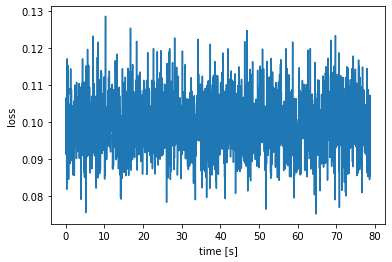

In [20]:
compare_with_GT(steps=2000, batch_size=256)

In [21]:
angles_predicted[0]

<tf.Variable 'Variable:0' shape=(4,) dtype=float64, numpy=array([0.41184277, 0.04738498, 0.33285514, 0.84696378])>

step 200/2000 (166s): loss = 1.41e-01
step 400/2000 (323s): loss = 1.01e-02
step 600/2000 (484s): loss = 1.58e-03
step 800/2000 (643s): loss = 2.14e-04
step 1000/2000 (803s): loss = 1.58e-05
step 1200/2000 (960s): loss = 8.30e-06
step 1400/2000 (1117s): loss = 8.75e-06
step 1600/2000 (1275s): loss = 8.79e-06
step 1800/2000 (1433s): loss = 7.73e-06
step 2000/2000 (1591s): loss = 7.60e-06


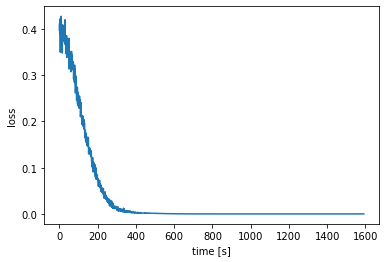

In [22]:
steps=2000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1 = list(np.random.randint(0, n_samples, batch_size))
    idx2 = list(np.random.randint(0, n_samples, batch_size))
    q1 = [angles_predicted[i] for i in idx1]
    q2 = [angles_predicted[i] for i in idx2]
    
    q1 = asserts.assert_normalized(q1)
    q2 = asserts.assert_normalized(q2)

    # Compute distances between projections
    p1 = [projections[i] for i in idx1]
    p2 = [projections[i] for i in idx2]
    distance_target = d_p(p1, p2)

    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(q1, q2, distance_target)
    optimizer.apply_gradients(zip(gradients, q1 + q2))

    q1 = quaternion.normalize(q1)
    q2 = quaternion.normalize(q2)

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    #if step> 400:break;
# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

In [23]:
angles_predicted[0]

<tf.Variable 'Variable:0' shape=(4,) dtype=float64, numpy=array([-0.00849807,  0.01268649,  0.00558655,  1.35681015])>

In [24]:
for i in range(len(angles_predicted)):
    angles_predicted[i] = quaternion.normalize(angles_predicted[i])

In [25]:
angles_predicted[0]

<tf.Tensor: id=9612051, shape=(4,), dtype=float64, numpy=array([-0.00626282,  0.00934956,  0.00411712,  0.9999282 ])>

step 200/2000 (7s): loss = 4.01e-01
step 400/2000 (15s): loss = 3.88e-01
step 600/2000 (22s): loss = 4.13e-01
step 800/2000 (29s): loss = 4.09e-01
step 1000/2000 (37s): loss = 4.17e-01
step 1200/2000 (44s): loss = 4.05e-01
step 1400/2000 (51s): loss = 4.10e-01
step 1600/2000 (59s): loss = 4.16e-01
step 1800/2000 (66s): loss = 4.31e-01
step 2000/2000 (73s): loss = 4.09e-01
Mean loss: 0.40091171444124973


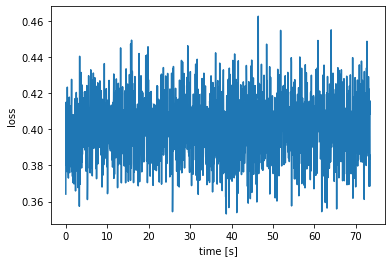

In [26]:
compare_with_GT(steps=2000, batch_size=256)